# Data Generation

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

## Swing Equation

From Newton's second law:

$$T_a(t) = J\alpha_m(t)= T_m(t) - T_e(t)$$

where

$$\alpha_m(t) = \frac{dw_m(t)}{dt} = \frac{d^2\theta_m(t)}{dt^2}$$

$$w_m(t) = \frac{d\theta_m(t)}{dt}$$

$T$ = torque (accelerating, mechanical and electrical) \[$\text{N-m}$\]

$J$ = moment of inertia \[$\text{kg}-m^2$\]

$\alpha$ = rotor angular acceleration \[$\text{rad}/s^2$\]

$w$ = rotor angular velocity \[$\text{rad}/s$\]

$\theta$ = rotor angle \[$\text{rad}$\]



In steady-state $T_m = T_e$ which makes $T_a = 0$, i.e. rotor acceleration is zero and constant rotor velocity (synchronous speed).

If we measure rotor angular position w.r.t. reference axis (synchronous):

$$\theta_m(t) = w_{msyn}t+\delta_m(t)$$

$w_{msyn}$ = synchronous angular velocity of rotor \[$\text{rad}/s$\]

$\delta_m$ = rotor angular position w.r.t. synchronous reference \[$\text{rad}$\]

Then:

$$J\frac{d^2\theta_m(t)}{dt^2} = J \frac{d^2\delta_m(t)}{dt^2} = T_m(t) - T_e(t) = T_a(t)$$

If mulitplying both sides by $w_m$ (to get power) and dividing by $\text{S}_{rated}$ (to get p.u.):

$$\frac{Jw_m(t)}{\text{S}_{rated}}\frac{d^2\theta_m(t)}{dt^2} = p_{m, pu}(t) - p_{e, pu} = p_{a, pu}(t)$$

Adding the damping term:

$$\frac{Jw_m(t)}{\text{S}_{rated}}\frac{d^2\theta_m(t)}{dt^2} + \frac{Dd\delta}{dt} = p_{m, pu}(t) - p_{e, pu} = p_{a, pu}(t)$$

## ODE formulation

Now that we defined the equation:

$$m_k \ddot{\delta} + d_k \dot{\delta} + B_{kj} V_k V_j sin(\delta) - P_1 = 0$$

We can express this second-order differential equation into a system of ODEs. First we define the state-vector:

$$\begin{bmatrix}x_1 \\ x_2\end{bmatrix} = \begin{bmatrix}
\delta\\
\dot{\delta}
\end{bmatrix}$$

where

$$\frac{d}{dt}\begin{bmatrix} \delta \\ \dot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix}$$

$$\begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \frac{P_1 - d \dot{\delta} - B\ \text{sin}\left( \delta_i - \delta_j \right)}{m} \end{bmatrix}$$

and, since $\delta_j$ is always zero in our case:

$$\begin{bmatrix} \dot{\delta} \\ \ddot{\delta} \end{bmatrix} = \begin{bmatrix} \dot{\delta} \\ \frac{P_1 - d \dot{\delta} - B\ \text{sin}\left( \delta \right)}{m} \end{bmatrix}$$

## Functions

In [44]:
def ode_rhs(t, state_variable, n_bus, m, d, B, power):
    """
    system of first order ordinary differential equations
    :param t: variable if ode depends on t
    :param state_variable: state vector consisting of delta_i and omega_i for i in 1:n_bus
    :param n_bus: number of buses
    :param m: inertia at each bus
    :param d: damping coefficient at each bus
    :param B: bus susceptance matrix
    :param power: power injection or retrieval at each bus
    :return: updated state variable
    """
    # split the state variable into delta and omega
    state_delta = state_variable[:n_bus].reshape((-1, 1))
    state_omega = state_variable[n_bus:].reshape((-1, 1))

    # computing the non-linear term in the swing equation sum_j (B_ij sin(delta_i - delta_j))
    delta_i = np.repeat(state_delta, repeats=n_bus, axis=1)
    delta_j = np.zeros_like(delta_i)
    delta_ij = np.sin(delta_i - delta_j)
    connectivity_vector = np.sum(np.multiply(B, delta_ij), axis=1).reshape((-1, 1))

    # update states
    state_delta_new = np.zeros_like(state_delta)
    state_omega_new = np.zeros_like(state_omega)

    for bus in range(n_bus):
        if m[bus] > 0:
            state_delta_new[bus] = state_omega[bus]
            state_omega_new[bus] = 1 / m[bus] * (
                        power[bus] - d[bus] * state_omega[bus] - connectivity_vector[bus])

    return np.concatenate([state_delta_new[:, 0],
                           state_omega_new[:, 0]],
                          axis=0)

def solve_ode(params):
    # TODO assess shapes
    
    # Unpack parameters
    m = params['inertia']
    d = params['damping']
    B = params['susceptance']
    power = params['power']
    delta_0 = params['delta_0']
    omega_0 = params['omega_0']
    t_min, t_max = params['t_span']
    n_bus = params['n_bus']
    n_data = params['n_data']
    
    # Define analysis time period and span
    t = np.linspace(t_min, t_max, n_data)
    t_span = (t_min, t_max)
    
    # Pack initial state
    initial_states = np.concatenate([delta_0, omega_0])
    
    # Solve ODE
    ode_solution = integrate.solve_ivp(ode_rhs,
                                       t_span=t_span,
                                       y0=initial_states,
                                       args=[n_bus, m, d, B, power],
                                       t_eval=t)
    
    # Reshape solution
    state_results = np.transpose(ode_solution.y)

    return state_results

## Driver

In [ ]:
# def main(params):

In [132]:
# Parameters
n_bus = 1 # number of buses
n_data = 100 # number of data points
# n_collocation = 80 # number of collocation points

m = np.array([0.4]) # angular inertia
d = np.array([0.15]) # damping coefficient
B = np.array([0.2]) # susceptance

power = np.array([0.2]) # power disturbance
delta_0 = np.array([0]) # initial angle
omega_0 = np.array([0]) # initial angular speed

t_min = 0
t_max = 10 # 20 too large, 10 should be enough
t_span = (t_min, t_max)

params = {'inertia': m,
          'damping': d,
          'susceptance': B,
          'power': power,
          'delta_0': delta_0,
          'omega_0': omega_0,
          'n_bus': n_bus,
          'n_data': n_data,
          't_span': t_span
         }

# Solve
sol = solve_ode(params)

In [133]:
sol.shape

(100, 2)

In [134]:
print(sol[:10])
print(sol[-10:])

[[0.         0.        ]
 [0.00251779 0.04951835]
 [0.00993403 0.09694862]
 [0.02202879 0.14213082]
 [0.03856684 0.18492203]
 [0.05930105 0.22519775]
 [0.08397258 0.26285198]
 [0.11231956 0.29780106]
 [0.14405925 0.32997317]
 [0.17890042 0.35931362]]
[[2.54488387 0.28063274]
 [2.57382976 0.29250735]
 [2.60401245 0.3051758 ]
 [2.63551375 0.31868689]
 [2.66842161 0.33309296]
 [2.70283022 0.34844991]
 [2.73883993 0.3648172 ]
 [2.77655726 0.38225782]
 [2.81609494 0.40083832]
 [2.85757189 0.42062881]]


# Data visualization

In [135]:
def plot_sol(sol):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
    t = np.linspace(t_min, t_max, n_data)
    ax1.plot(t, sol[:,0])
    ax1.set_title("Angle vs. Time")
    ax1.set(xlabel="Time [s]", ylabel="δ [rad]")
    ax2.plot(t, sol[:,1], 'r')
    ax2.set_title("Angular speed vs. Time")
    ax2.set(xlabel="Time [s]", ylabel="ω [rad/s]")
    plt.tight_layout()

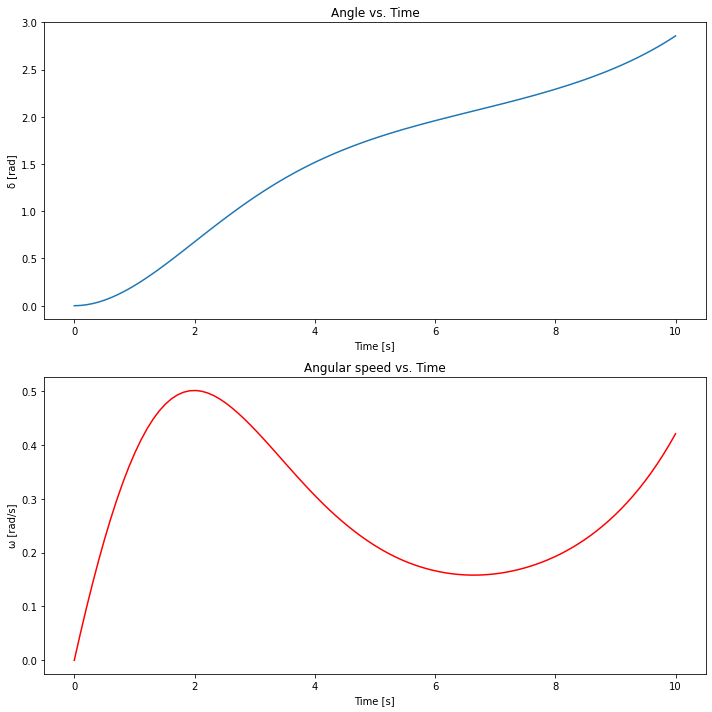

In [136]:
plot_sol(sol)

Text(0, 0.5, 'ω [rad/s]')

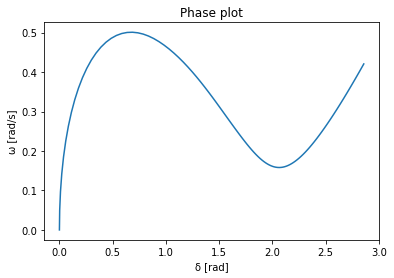

In [137]:
plt.plot(sol[:,0], sol[:,1])
plt.title("Phase plot")
plt.xlabel("δ [rad]")
plt.ylabel("ω [rad/s]")

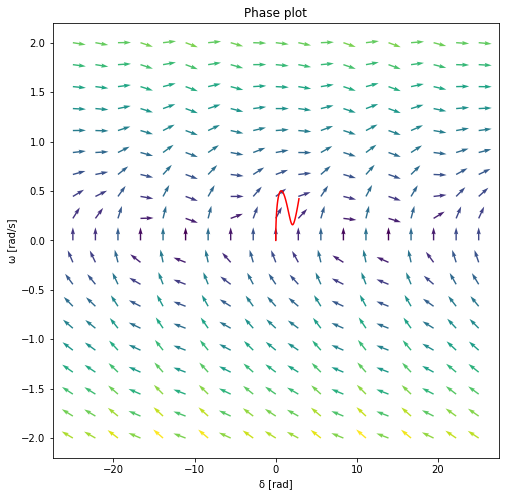

In [138]:
delta = np.linspace(-25, 25, 19)
omega = np.linspace(-2, 2, 19)
dlt, omg  = np.meshgrid(delta, omega)

u, v = np.zeros(dlt.shape), np.zeros(omg.shape)

n_i, n_j = dlt.shape

for i in range(n_i):
    for j in range(n_j):
        x = dlt[i, j]
        y = omg[i, j]
        sol_v = ode_rhs(1, np.array([x, y]), n_bus, m, d, B, power)
        u[i,j] = sol_v[0]
        v[i,j] = sol_v[1]

M = (np.hypot(u, v)) # get length of vector
M[ M == 0] = 1. # avoid zero division errors 
u /= M # normalize
v /= M # normalize

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.quiver(dlt, omg, u, v, M)
ax.plot(sol[:,0], sol[:,1], 'r')
ax.set_title("Phase plot")
ax.set(xlabel="δ [rad]", ylabel="ω [rad/s]")
fig.show()

## .ipynb to .py

In [ ]:
# if __name__ == '__main__':
#     main()